<a href="https://colab.research.google.com/github/uptotec/COVID-from-CT-model/blob/main/detect_COVID_19_from_CT_scans_using_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect COVId-19 from CT Scans using AI
#### This Ai model made with fast.ai library and dataset from kaggle

# Downloading the images dataset from kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d azaemon/preprocessed-ct-scans-for-covid19

100% 3.57G/3.59G [01:08<00:00, 61.4MB/s]
100% 3.59G/3.59G [01:08<00:00, 56.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('preprocessed-ct-scans-for-covid19.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

# Setting up the training eniveronment and virifing the images

In [ ]:
from fastai.vision import *
import os

In [ ]:
# to save the models
model_path = 'models'

# to save the plk models
plk_path = 'plk'

# to save the plots
plot_path = 'plots'

if not os.path.exists(model_path):
    os.makedirs(model_path)
    os.makedirs(os.path.join(model_path, plot_path))
    os.makedirs(os.path.join(model_path, plk_path))

In [ ]:
classes = ['nCT', 'pCT']

In [ ]:
!rm -rf /content/files/"Original CT Scans"/NiCT

In [ ]:
path = Path('/content/files/Original CT Scans')
path.ls()

[PosixPath('/content/files/Original CT Scans/nCT'),
 PosixPath('/content/files/Original CT Scans/pCT')]

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=700)

nCT


pCT


# Creating the data and learner objects

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.25, 
                                  ds_tfms=get_transforms(), size=512, 
                                  num_workers=4, bs=10).normalize(imagenet_stats)

In [ ]:
print(data.classes, len(data.train_ds), len(data.valid_ds))

['nCT', 'pCT'] 10485 3495


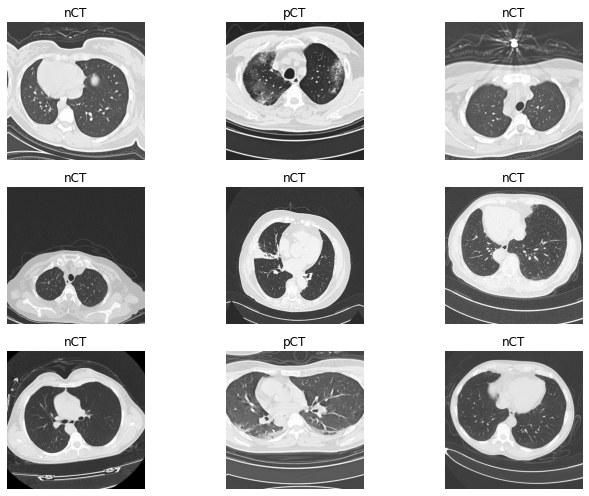

In [ ]:
data.show_batch(rows=3, figsize=(10, 7))

In [ ]:
learn = cnn_learner(data, models.resnet34, 
                    metrics=[accuracy, error_rate], 
                    model_dir='/content/models')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Training the first stage (outer layers)

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.228157,0.097004,0.965951,0.034049,07:25
1,0.125042,0.029685,0.991989,0.008011,07:24
2,0.036351,0.019522,0.993705,0.006295,07:25
3,0.034799,0.019208,0.995422,0.004578,07:21
4,0.016791,0.016448,0.995708,0.004292,07:22


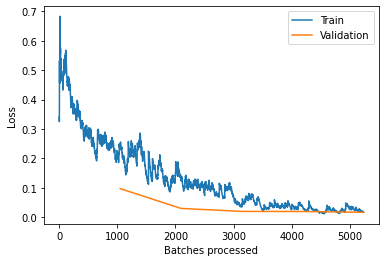

In [ ]:
learn.recorder.plot_losses()

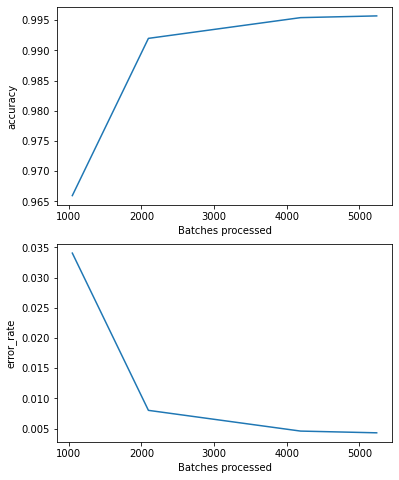

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('stage1', return_path=True)

PosixPath('/content/models/stage1.pth')

In [ ]:
learn.export(os.path.abspath('./models/plk/stage1.pkl'))

# Training the second stage (inner layers)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


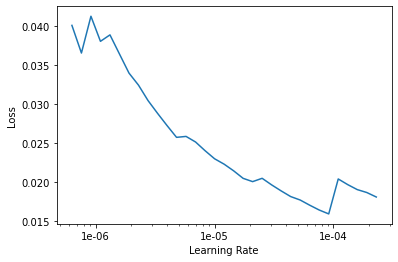

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(3e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.044586,0.030695,0.991130,0.008870,07:16
1,0.047059,0.076988,0.979685,0.020315,07:03
2,0.015626,0.009037,0.997711,0.002289,06:57
3,0.009165,0.002862,0.999142,0.000858,06:59
4,0.017946,0.002559,0.999714,0.000286,06:56


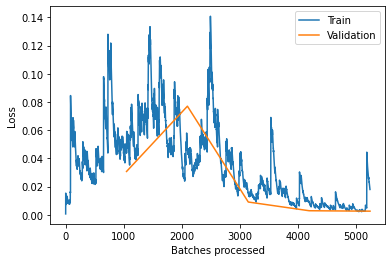

In [ ]:
learn.recorder.plot_losses()

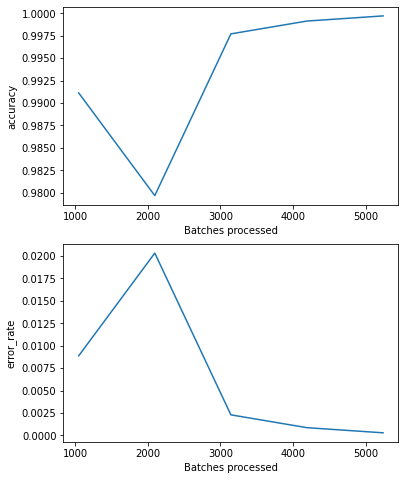

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('stage2', return_path=True)

PosixPath('/content/models/stage2.pth')

In [ ]:
learn.export(os.path.abspath('./models/plk/stage2.pkl'))

# Downloading the model after training

In [ ]:
import shutil
shutil.make_archive('final-output', 'zip', '/content/models')

'/content/final-output.zip'

In [ ]:
from google.colab import files
files.download('final-output.zip');

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Creating the confusion matrix and validating the model

In [ ]:
learn.load('stage2')

Learner(data=ImageDataBunch;

Train: LabelList (10485 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
nCT,nCT,nCT,nCT,nCT
Path: /content/files/Original CT Scans;

Valid: LabelList (3495 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
pCT,pCT,nCT,nCT,nCT
Path: /content/files/Original CT Scans;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

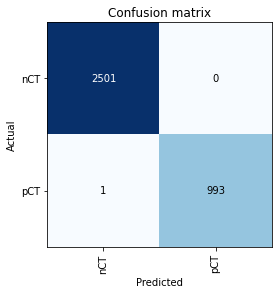

In [ ]:
interp.plot_confusion_matrix()
plt.savefig('models/plots/interp.png')
plt.show()

In [ ]:
learn.validate()

[0.0025586553, tensor(0.9997), tensor(0.0003)]